<h3>Length of Stay Model Building and Exploration</h3><br />
This notebook shows the process of building classification models for length of stay. It shows the performance of models with different bin sizes, different models, and upsampling techniques. This notebook also contains an evaluation of model performance across sub-populations.

In [1]:
#Import all needed models
import sys
sys.path.insert(0, '../src/helpers')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, f1_score, classification_report, make_scorer, precision_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
from model_building_helpers import *
from data_cleaners import *

In [2]:
#Load all patient csv (csv containing data for all the indications (COPD, Heart Failure, Schizophrenia, Knee Replacement, Kidney/UTI))
all_patient_df = load_data('All')

All
..\data\processed\Hospital_Inpatient_Discharges_17_18_cleaned.csv
All


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Use the following two cells to see how changing the bin definitions changes the accuracy and confusion matrix of the model.

In [3]:
#Bin the data by length of stay ranges
bins = [1, 5, 15, 30, 45, 60, 90, 120]
labels = ['1 to 5', '6 to 15', '16 to 30', '31 to 45', '46 to 60', '60 to 90', '90 to 120']

all_patient_df_bins = all_patient_df.copy()
all_patient_df_bins['Length of Stay Bin'] = pd.cut(x = all_patient_df_bins['Length of Stay'], bins = bins, labels = labels, include_lowest = True)

In [4]:
X, y, X_train, X_test, y_train, y_test = get_train_test_data(all_patient_df_bins)

model = RandomForestClassifier()
model.fit(X_train, np.ravel(y_train))
y_pred = model.predict(X_test)
bin1_accuracy = accuracy_score(y_test, y_pred)
bin1_f1_score_macro = f1_score(y_test, y_pred, average='macro')
bin1_f1_score_weighted = f1_score(y_test, y_pred, average='weighted')
cf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy = ", bin1_accuracy, "\nF1 Macro Score = ", bin1_f1_score_macro, "\nF1 Weighted Score = ", bin1_f1_score_weighted)

Accuracy =  0.6876805259957434 
F1 Macro Score =  0.22878151912891279 
F1 Weighted Score =  0.6709925806775825


<AxesSubplot:title={'center':'Confusion Matrix For Random Forest Model'}>

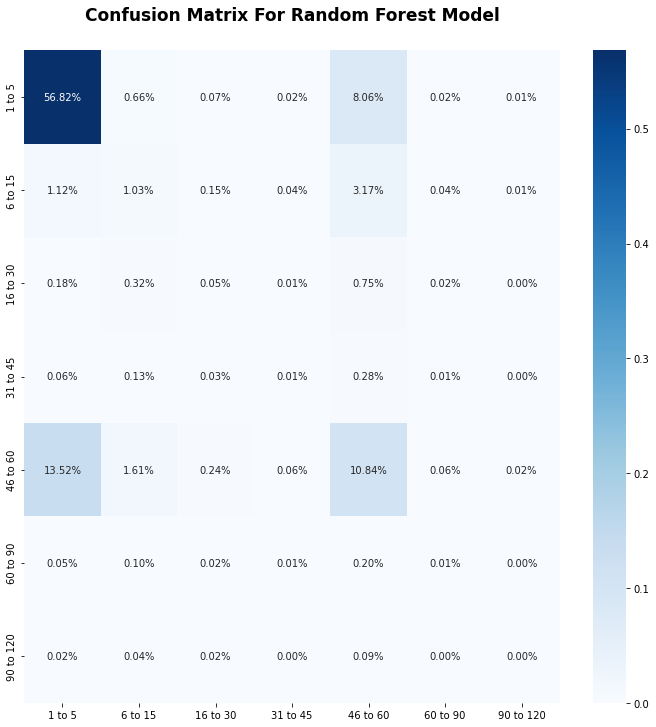

In [5]:
#Visualize the confusion matrix as a heart map
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (12, 12))
plt.title('Confusion Matrix For Random Forest Model', fontsize=17, weight='bold', pad=30)
sns.heatmap(df_cm, annot=True, fmt='.2%',  cmap='Blues')

In [6]:
#Get RandomForest best parameters and best score by sub-population
#Experiment model performance by changing the parameters tested and interations for the RandomizedSearch
rf_scores = []
iterations = 10 #We found the iterations did not affect F1 macro scores much, so we used the default of 10

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg)
    subpop_df['Length of Stay Bin'] = pd.cut(x = subpop_df['Length of Stay'], bins = bins, labels = labels, include_lowest = True)
    if len(subpop_df) > 30000:
        subpop_df = subpop_df.groupby('Length of Stay Bin', group_keys=False).apply(lambda x: x.sample(int(np.rint(30000*len(x)/len(subpop_df))))).sample(frac=1).reset_index(drop=True)
        
    X, y, X_train, X_test, y_train, y_test = get_train_test_data(subpop_df)

    random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 800, num = 15)],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False],
               'class_weight': ['balanced', 'balanced_subsample']}
    
    best_params, best_score = get_best_rf_params(X_train, y_train, random_grid, iterations)
    rf_scores.append({drg:{
            'best_params': best_params,
            'best_score': best_score
            }
        }
    )

all
..\data\processed\Hospital_Inpatient_Discharges_17_18_cleaned.csv
all


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.2530538667489449
194.0
..\data\processed\HID_cleaned_HeartFailure.csv
194.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.2011607484729767
140.0
..\data\processed\HID_cleaned_ChronicObstructivePulmonaryDisease.csv
140.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.1956061406380666
750.0
..\data\processed\HID_cleaned_Schizophrenia.csv
750.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.18308780022116175
463.0
..\data\processed\HID_cleaned_Kidney&UrinaryTractInfections.csv
463.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.1839136130058243
302.0
..\data\processed\HID_cleaned_KneeJointReplacement.csv
302.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0.24436572785031882


In [7]:
#Get LogisticRegression best parameters and best score by sub-population
#Experiment model performance by changing the parameters tested and interations for the RandomizedSearch
lr_scores = []
iterations = 10 #We found the iterations did not affect F1 macro scores much, so we used the default of 10

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg)
    subpop_df['Length of Stay Bin'] = pd.cut(x = subpop_df['Length of Stay'], bins = bins, labels = labels, include_lowest = True)
    if len(subpop_df) > 30000:
        subpop_df = subpop_df.groupby('Length of Stay Bin', group_keys=False).apply(lambda x: x.sample(int(np.rint(30000*len(x)/len(subpop_df))))).sample(frac=1).reset_index(drop=True)
        
    X, y, X_train, X_test, y_train, y_test = get_train_test_data(subpop_df)

    random_grid = {'C' : np.logspace(0, 4, num=10),
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear'],
    'class_weight': ['balanced', None]}
    
    best_params, best_score = get_best_lr_params(X_train, y_train, random_grid, iterations)
    lr_scores.append({drg:{
            'best_params': best_params,
            'best_score': best_score
            }
        }
    )

all
..\data\processed\Hospital_Inpatient_Discharges_17_18_cleaned.csv
all


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


194.0
..\data\processed\HID_cleaned_HeartFailure.csv
194.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


140.0
..\data\processed\HID_cleaned_ChronicObstructivePulmonaryDisease.csv
140.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


750.0
..\data\processed\HID_cleaned_Schizophrenia.csv
750.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


463.0
..\data\processed\HID_cleaned_Kidney&UrinaryTractInfections.csv
463.0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


302.0
..\data\processed\HID_cleaned_KneeJointReplacement.csv
302.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [8]:
scores_rf_df = pd.DataFrame(columns=['model', 'subpopulation', 'best_params', 'best_scores'])
for item in rf_scores:
    for key, item in item.items():
        scores_rf_df = scores_rf_df.append({'model': 'RandomForestClassifier', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
scores_rf_df.head()

scores_lr_df = pd.DataFrame(columns=['model', 'subpopulation', 'best_params', 'best_scores'])
for item in lr_scores:
    for key, item in item.items():
        scores_lr_df = scores_lr_df.append({'model': 'LogisticRegression', 'subpopulation': key, 'best_params': item['best_params'], 'best_scores': item['best_score']}, ignore_index=True)
scores_lr_df.head()

randomized_search_results = pd.concat([scores_rf_df,scores_lr_df])
print(randomized_search_results)

                    model subpopulation  \
0  RandomForestClassifier           all   
1  RandomForestClassifier         194.0   
2  RandomForestClassifier         140.0   
3  RandomForestClassifier         750.0   
4  RandomForestClassifier         463.0   
5  RandomForestClassifier         302.0   
0      LogisticRegression           all   
1      LogisticRegression         194.0   
2      LogisticRegression         140.0   
3      LogisticRegression         750.0   
4      LogisticRegression         463.0   
5      LogisticRegression         302.0   

                                         best_params  best_scores  
0  {'n_estimators': 600, 'min_samples_split': 5, ...     0.253054  
1  {'n_estimators': 150, 'min_samples_split': 2, ...     0.201161  
2  {'n_estimators': 750, 'min_samples_split': 10,...     0.195606  
3  {'n_estimators': 700, 'min_samples_split': 10,...     0.183088  
4  {'n_estimators': 400, 'min_samples_split': 5, ...     0.183914  
5  {'n_estimators': 150, 'min_sa

Text(0.5, 1.0, 'Patients with DRG Code 302 (Knee Joint Replacement)')

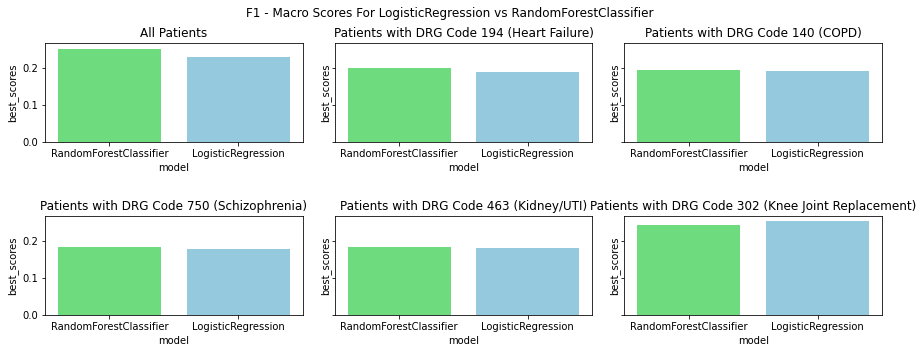

In [9]:
#Create visualization for each subpopulation for each model
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True)

fig.subplots_adjust(hspace=0.75, wspace=0.125)


fig.suptitle('F1 - Macro Scores For LogisticRegression vs RandomForestClassifier')

all_patients = randomized_search_results[randomized_search_results['subpopulation'] == 'all']
heart_patients = randomized_search_results[randomized_search_results['subpopulation'] == 194.0]
copd_patients = randomized_search_results[randomized_search_results['subpopulation'] == 140.0]
schizophrenia_patients = randomized_search_results[randomized_search_results['subpopulation'] == 750.0]
kidney_patients = randomized_search_results[randomized_search_results['subpopulation'] == 463.0]
knee_rep_patients = randomized_search_results[randomized_search_results['subpopulation'] == 302.0]

sns.barplot(ax=axes[0, 0], x=all_patients['model'], y=all_patients['best_scores'], palette=['#5CED73', 'skyblue'])
axes[0, 0].set_title('All Patients')

sns.barplot(ax=axes[0, 1], x=heart_patients['model'], y=heart_patients['best_scores'], palette=['#5CED73', 'skyblue'])
axes[0, 1].set_title('Patients with DRG Code 194 (Heart Failure)')

sns.barplot(ax=axes[0, 2], x=copd_patients['model'], y=copd_patients['best_scores'], palette=['#5CED73', 'skyblue'])
axes[0, 2].set_title('Patients with DRG Code 140 (COPD)')

sns.barplot(ax=axes[1, 0], x=schizophrenia_patients['model'], y=schizophrenia_patients['best_scores'], palette=['#5CED73', 'skyblue'])
axes[1, 0].set_title('Patients with DRG Code 750 (Schizophrenia)')

sns.barplot(ax=axes[1, 1], x=kidney_patients['model'], y=kidney_patients['best_scores'], palette=['#5CED73', 'skyblue'])
axes[1, 1].set_title('Patients with DRG Code 463 (Kidney/UTI)')

sns.barplot(ax=axes[1, 2], x=knee_rep_patients['model'], y=knee_rep_patients['best_scores'], palette=['#5CED73', 'skyblue'])
axes[1, 2].set_title('Patients with DRG Code 302 (Knee Joint Replacement)')

It looks like for most models, the RandomForestClassifier does as good or better than the LogisticRegression model, with the exception of the models trained on Knee Replacement patients. Let's train each subpopulation on their best parameters for RandomForestClassifier model.

In [19]:
final_model_scores = []

for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    subpop_df = load_data(drg)
    subpop_df['Length of Stay Bin'] = pd.cut(x = subpop_df['Length of Stay'], bins = bins, labels = labels, include_lowest = True)
      
    X, y, X_train, X_test, y_train, y_test = get_train_test_data(subpop_df)

    best_params = scores_rf_df.loc[(scores_rf_df['model']=='RandomForestClassifier') & (scores_rf_df['subpopulation']==drg)]['best_params'].values[0]
    model_scores = get_model_scores(best_params, X_train, X_test, y_train, y_test)
    final_model_scores.append({
        'Model': 'RandomForestClassifier',
        'Population': drg,
        'Accuracy Score': model_scores[0],
        'F1_score_macro': model_scores[1],
        'F1_score_weighted': model_scores[2]
    })

final_results_df = pd.DataFrame(final_model_scores)

all
..\data\processed\Hospital_Inpatient_Discharges_17_18_cleaned.csv
all


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Training model
Getting model scores
194.0
..\data\processed\HID_cleaned_HeartFailure.csv
194.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Training model
Getting model scores
140.0
..\data\processed\HID_cleaned_ChronicObstructivePulmonaryDisease.csv
140.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Training model
Getting model scores
750.0
..\data\processed\HID_cleaned_Schizophrenia.csv
750.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Training model
Getting model scores
463.0
..\data\processed\HID_cleaned_Kidney&UrinaryTractInfections.csv
463.0
Training model
Getting model scores
302.0
..\data\processed\HID_cleaned_KneeJointReplacement.csv
302.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Training model
Getting model scores


Text(0.5, 1.0, 'Accuracy Score Across Populations')

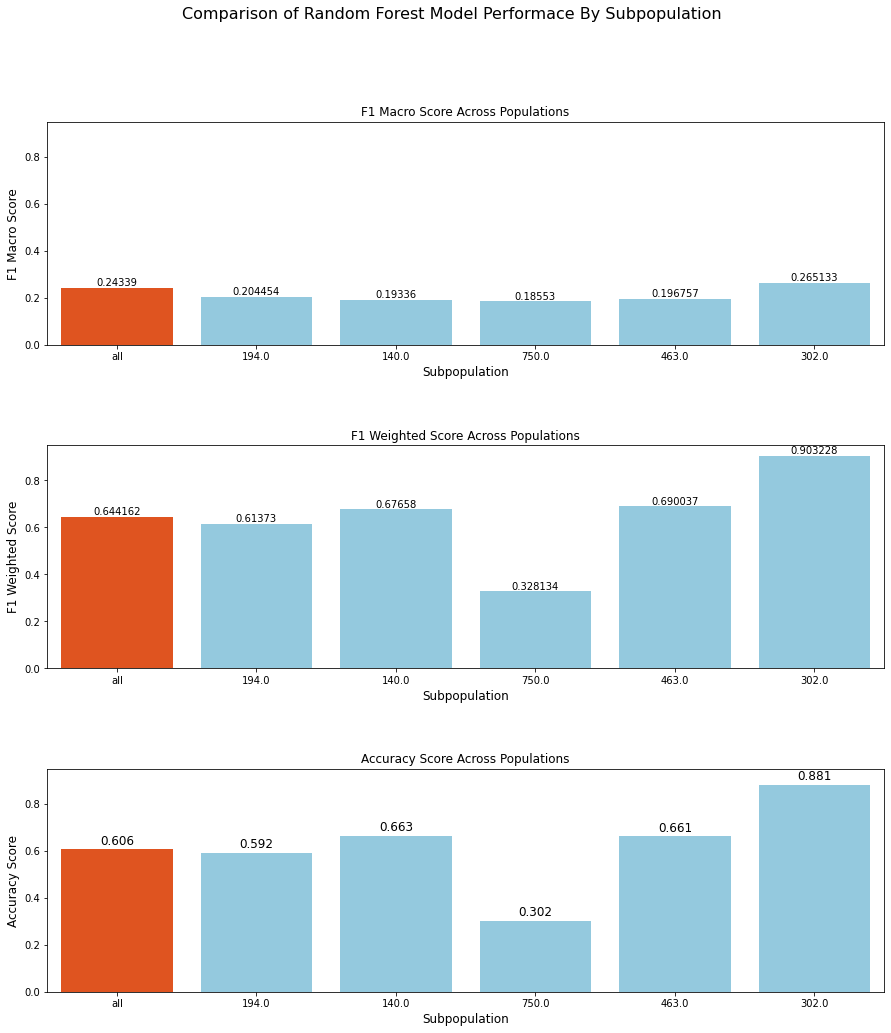

In [20]:
#Visualize the results
#Build visualization comparing random forest model performance of all populations
colors = ['orangered' if (x == 'all') else 'skyblue' for x in final_results_df['Population'].values]

fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharey=True)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Comparison of Random Forest Model Performace By Subpopulation', fontsize=16)

sns.barplot(ax=axes[0], x=final_results_df['Population'], y=final_results_df['F1_score_macro'], palette=colors)
axes[0].set_xlabel('Subpopulation', fontsize=12)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title('F1 Macro Score Across Populations')

sns.barplot(ax=axes[1], x=final_results_df['Population'], y=final_results_df['F1_score_weighted'], palette=colors)
axes[1].set_xlabel('Subpopulation', fontsize=12)
axes[1].set_ylabel('F1 Weighted Score', fontsize=12)
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title('F1 Weighted Score Across Populations')

sns.barplot(ax=axes[2], x=final_results_df['Population'], y=final_results_df['Accuracy Score'], palette=colors)
axes[2].set_xlabel('Subpopulation', fontsize=12)
axes[2].set_ylabel('Accuracy Score', fontsize=12)
axes[2].bar_label(axes[2].containers[0], fmt='%.3f', padding=2, fontsize=12)
axes[2].set_title('Accuracy Score Across Populations')

From the visualization above, it can be seen that for F1 macro scores the model built on all conditions of interest outperforms models trained only on patients with a specific DRG code with the exception of Knee replacement patients.
<br /><br />
Let's also compare performance with a dummy classifier which predicts the majority class every time and a dummy classifier which selects a class at random.

In [21]:
#Get dummy model performance on all the population datasets
final_model_scores = []

#all population
for drg in ['all', 194.0, 140.0, 750.0, 463.0, 302.0]:
    print(drg)
    subpop_df = load_data(drg)
    subpop_df['Length of Stay Bin'] = pd.cut(x = subpop_df['Length of Stay'], bins = bins, labels = labels, include_lowest = True)
      
    X, y, X_train, X_test, y_train, y_test = get_train_test_data(subpop_df)
    
    most_freq_dummy_scores = get_dummy_scores("most_frequent", X_train, X_test, y_train, y_test)

    final_model_scores.append({
        'Population': drg,
        'Model': 'DummyClassifier - Most Frequent',
        'Accuracy Score': most_freq_dummy_scores[0],
        'F1_score_macro': most_freq_dummy_scores[1],
        'F1_score_weighted': most_freq_dummy_scores[2]
    })

    random_dummy_scores = get_dummy_scores("uniform", X_train, X_test, y_train, y_test)

    final_model_scores.append({
        'Population': drg,
        'Model': 'DummyClassifier - Random',
        'Accuracy Score': random_dummy_scores[0],
        'F1_score_macro': random_dummy_scores[1],
        'F1_score_weighted': random_dummy_scores[2]
    })

all
all
..\data\processed\Hospital_Inpatient_Discharges_17_18_cleaned.csv
all


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


194.0
194.0
..\data\processed\HID_cleaned_HeartFailure.csv
194.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


140.0
140.0
..\data\processed\HID_cleaned_ChronicObstructivePulmonaryDisease.csv
140.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


750.0
750.0
..\data\processed\HID_cleaned_Schizophrenia.csv
750.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


463.0
463.0
..\data\processed\HID_cleaned_Kidney&UrinaryTractInfections.csv
463.0
302.0
302.0
..\data\processed\HID_cleaned_KneeJointReplacement.csv
302.0


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [22]:
final_scores_df = pd.DataFrame(final_model_scores)
final_results_with_dummy_df = pd.concat([final_results_df, final_scores_df], ignore_index=True)
print(final_results_with_dummy_df)

                              Model Population  Accuracy Score  \
0            RandomForestClassifier        all        0.605522   
1            RandomForestClassifier      194.0        0.591588   
2            RandomForestClassifier      140.0        0.663101   
3            RandomForestClassifier      750.0        0.302049   
4            RandomForestClassifier      463.0        0.660762   
5            RandomForestClassifier      302.0        0.880591   
6   DummyClassifier - Most Frequent        all        0.657590   
7          DummyClassifier - Random        all        0.143271   
8   DummyClassifier - Most Frequent      194.0        0.630392   
9          DummyClassifier - Random      194.0        0.143331   
10  DummyClassifier - Most Frequent      140.0        0.733180   
11         DummyClassifier - Random      140.0        0.142107   
12  DummyClassifier - Most Frequent      750.0        0.459789   
13         DummyClassifier - Random      750.0        0.140584   
14  DummyC

Text(0.5, 1.0, 'Accuracy Scores')

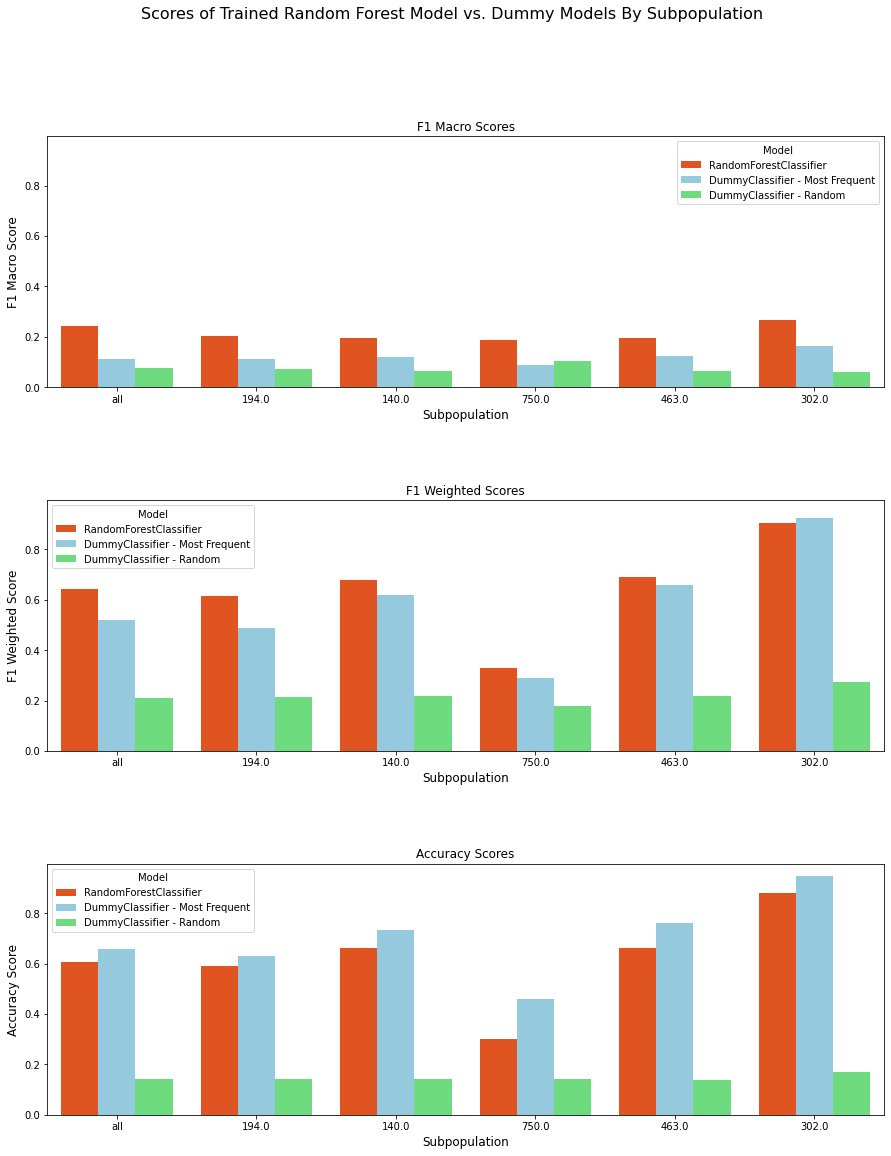

In [23]:
#Plot dummy classifiers vs rf model performance for each population
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharey=True)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Scores of Trained Random Forest Model vs. Dummy Models By Subpopulation', fontsize=16)

sns.barplot(ax=axes[0], data=final_results_with_dummy_df, x="Population", y="F1_score_macro", hue="Model",palette= ['orangered', 'skyblue', '#5CED73'])
axes[0].set_xlabel('Subpopulation', fontsize=12)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
#axes[0].bar_label(axes[0].containers[0])
axes[0].set_title('F1 Macro Scores')

sns.barplot(ax=axes[1], data=final_results_with_dummy_df, x="Population", y="F1_score_weighted", hue="Model",palette= ['orangered', 'skyblue', '#5CED73'])
axes[1].set_xlabel('Subpopulation', fontsize=12)
axes[1].set_ylabel('F1 Weighted Score', fontsize=12)
#axes[1].bar_label(axes[1].containers[0])
axes[1].set_title('F1 Weighted Scores')

sns.barplot(ax=axes[2], data=final_results_with_dummy_df, x="Population", y="Accuracy Score", hue="Model",palette= ['orangered', 'skyblue', '#5CED73'])
axes[2].set_xlabel('Subpopulation', fontsize=12)
axes[2].set_ylabel('Accuracy Score', fontsize=12)
#axes[2].bar_label(axes[2].containers[0])
axes[2].set_title('Accuracy Scores')

The models do outperform the dummy models, especially when comparing the F1 Macro score. However, overall we can see that the F1 macro scores are still fairly low for the trained models. This is due to the class imbalance we see in the dataset. About 65% of patients stay in the hospital 1 - 5 days. This is about the same as our accuracy and weighted F1 scores.
<br /><br />
As a next step, let's see if upsampling our tarining data for the 'All patients' model makes a difference to the F1 macro score

In [38]:
oversample_scores = []

oversample = SMOTE()

best_params = scores_rf_df.loc[(scores_rf_df['model']=='RandomForestClassifier') & (scores_rf_df['subpopulation']=='all')]['best_params'].values[0]

subpop_df = load_data('all')
subpop_df['Length of Stay Bin'] = pd.cut(x = subpop_df['Length of Stay'], bins = bins, labels = labels, include_lowest = True)
      
X, y, X_train, X_test, y_train, y_test = get_train_test_data(subpop_df)

X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

oversampled_model = train_model(best_params, X_train_resample, y_train_resample)

model_scores = calculate_scores(oversampled_model, X_test, y_test)

oversample_scores.append({
    'Population': 'all',
    'Model': 'RandomForestClassifier - Upsampled',
    'Accuracy Score': model_scores[0],
    'F1_score_macro': model_scores[1],
    'F1_score_weighted': model_scores[2]
})

final_results_df = final_results_df.append(oversample_scores)
final_results_df

all
..\data\processed\Hospital_Inpatient_Discharges_17_18_cleaned.csv
all


C:\Users\Urvi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Training model
Getting model scores


,Model,Population,Accuracy Score,F1_score_macro,F1_score_weighted
0,RandomForestClassifier,all,0.605522,0.243390,0.644162
1,RandomForestClassifier,194.0,0.591588,0.204454,0.613730
2,RandomForestClassifier,140.0,0.663101,0.193360,0.676580
3,RandomForestClassifier,750.0,0.302049,0.185530,0.328134
4,RandomForestClassifier,463.0,0.660762,0.196757,0.690037
5,RandomForestClassifier,302.0,0.880591,0.265133,0.903228
0,RandomForestClassifier - Upsampled,all,0.599840,0.238822,0.639214
0,RandomForestClassifier - Upsampled,all,0.632297,0.254225,0.658177


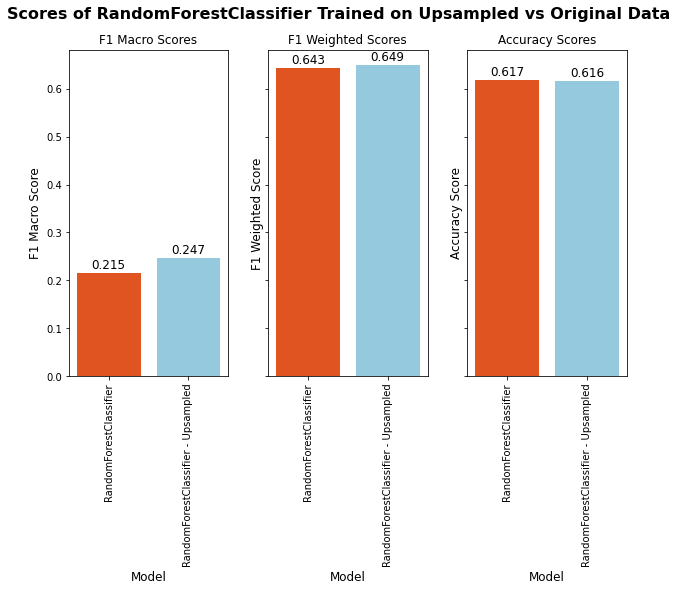

In [45]:
#Plot dummy classifiers vs rf model performance for each population
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
fig.subplots_adjust(hspace=0.45, wspace=0.25)
fig.suptitle('Scores of RandomForestClassifier Trained on Upsampled vs Original Data', fontsize=16, fontweight='bold')

final_results_upsampled = final_results_df[final_results_df['Population'] == 'all']
sns.barplot(ax=axes[0], data=final_results_df, x="Model", y="F1_score_macro", palette= ['orangered', 'skyblue'], ci=None)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('F1 Macro Score', fontsize=12)
axes[0].bar_label(axes[0].containers[0], fmt='%.3f', padding=2, fontsize=12)
axes[0].set_title('F1 Macro Scores')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[1], data=final_results_df, x="Model", y="F1_score_weighted", palette= ['orangered', 'skyblue'], ci=None)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('F1 Weighted Score', fontsize=12)
axes[1].bar_label(axes[1].containers[0], fmt='%.3f', padding=2, fontsize=12)
axes[1].set_title('F1 Weighted Scores')
axes[1].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[2], data=final_results_df, x="Model", y="Accuracy Score", palette= ['orangered', 'skyblue'], ci=None)
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('Accuracy Score', fontsize=12)
axes[2].bar_label(axes[2].containers[0], fmt='%.3f', padding=2, fontsize=12)
axes[2].set_title('Accuracy Scores')
axes[2].tick_params(axis='x', rotation=90)
#plt.savefig('../src/visualizations/upsampled_vs_original.png')

In [40]:
data={'feature_names':oversampled_model.feature_names_in_,'feature_importance':oversampled_model.feature_importances_}
features_importance_df = pd.DataFrame(data)
features_importance_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
features_importance_df.head()
feature_importance_to_20_df = features_importance_df[0:20]

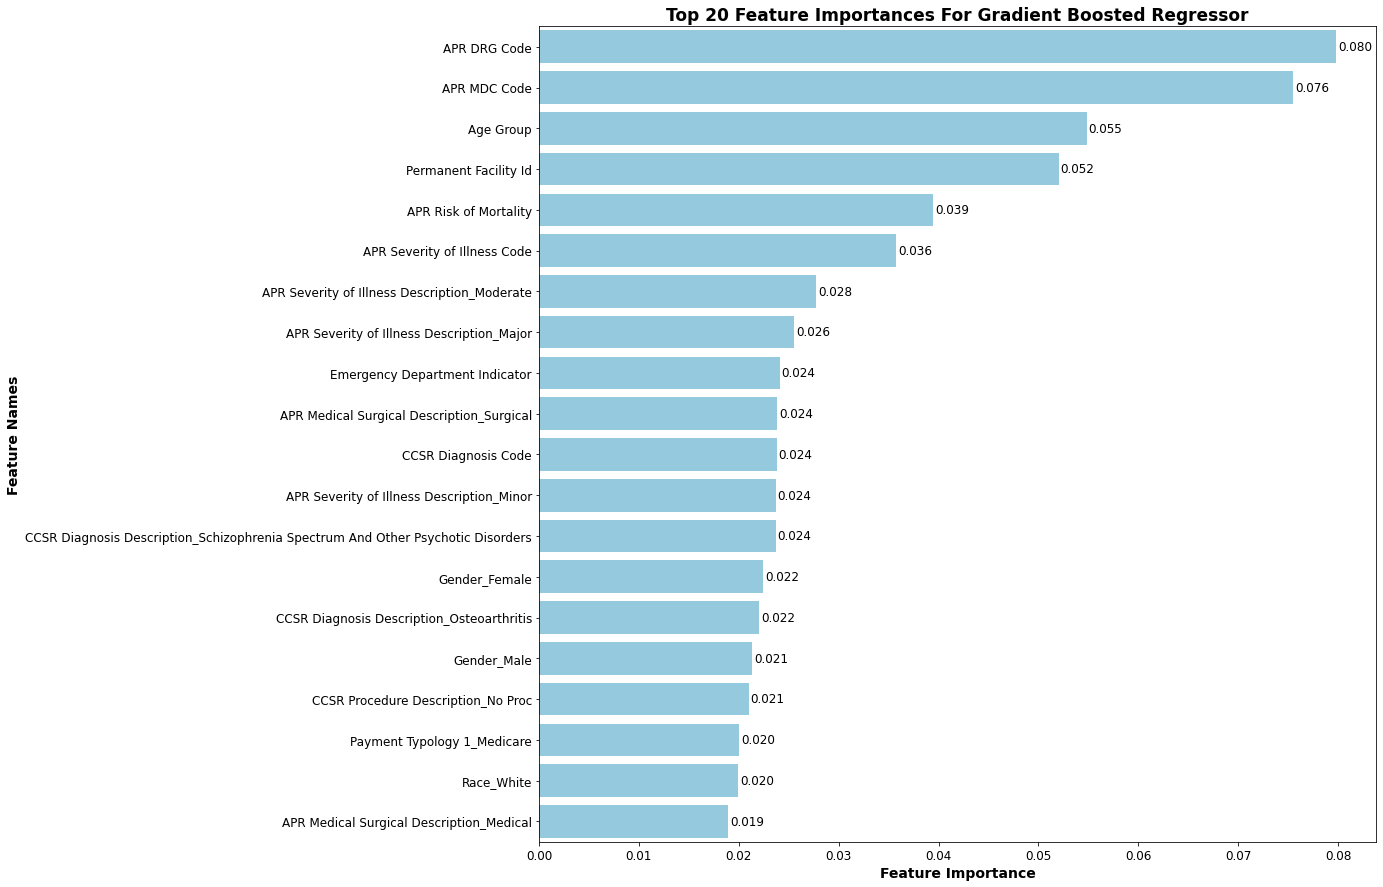

In [44]:
plt.figure(figsize=(15,15))

sns_barplot = sns.barplot(x=feature_importance_to_20_df['feature_importance'], y=feature_importance_to_20_df['feature_names'], palette = ['skyblue'])
plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Feature Names', fontsize=14, fontweight='bold')
plt.title('Top 20 Feature Importances For Gradient Boosted Regressor', fontsize=17, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.bar_label(sns_barplot.containers[0], fmt='%.3f', padding=2, fontsize=12)
#plt.savefig('../src/visualizations/classification_feature_importance.png')